In [1]:
library(tidyverse)
library(readr)
library(ggrepel)

read_my_data <- function(file_path) {
  my_data <- read_delim(file_path, delim = "\t", skip = 1, 
                        col_names = c("chrom", "start", "stop", "acr_name", 
                                      "freq", "intron_overlap", 
                                      "tss_overlap", "promoter_overlap", 
                                      "intergenic_overlap"))
    
    
  return(my_data)
}


zm_annotation <- read_my_data("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/annotate_bulk/Zm.all_ACRs.annotated.bed")
sb_annotation <- read_my_data("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/annotate_bulk/Sb.all_ACRs.annotated.bed")



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.1          v readr     2.1.4     
v forcats   1.0.0.9000     v stringr   1.5.0     
v ggplot2   3.4.2          v tibble    3.2.1     
v lubridate 1.9.2          v tidyr     1.3.0     
v purrr     1.0.1          
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 55543 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chrom, acr_name, freq
dbl (6): start, stop, intron_overlap, tss_overlap, promoter_overlap, interge...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 65788 Columns: 9
-- Column specificatio

In [2]:
categroize_acrs <- function(df) {
    
    df_categorized <- df %>%
    rowwise() %>%
    mutate(class = case_when(
      intron_overlap >= tss_overlap & 
        intron_overlap >= promoter_overlap & 
        intron_overlap >= intergenic_overlap ~ "intron_overlap",
      tss_overlap > 0 ~ "tss_overlap",
      promoter_overlap >= intergenic_overlap ~ "promoter_overlap",
      TRUE ~ "intergenic_overlap"
    ))
  return(df_categorized)
}



In [3]:
zm_annotation_categorized  <- categroize_acrs(zm_annotation)
sb_annotation_categorized <- categroize_acrs(sb_annotation)

In [4]:
  class_counts <- sb_annotation_categorized %>% 
    group_by(class = str_replace_all(class, "_", " ")) %>% 
    summarise(n = n())

class_counts

class,n
<chr>,<int>
intergenic overlap,30744
intron overlap,7967
promoter overlap,8105
tss overlap,18972


In [19]:
# Function to generate pie chart
pie_chart <- function(dataframe, species) {
    colors_large <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                  "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                  "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")

    
  # Group the data by class and count the number of observations in each group
  class_counts <- dataframe %>% 
    group_by(class = str_replace_all(class, "_", " ")) %>% 
    summarise(n = n())
  
  # Generate the pie chart
 p <- ggplot(class_counts, aes(x = "", y = n, fill = class)) +
    geom_bar(stat = "identity", width = 1, position = position_stack(vjust = 0.5)) +
    scale_fill_manual(values = colors_large) +
    coord_polar(theta = "y") +
    labs(fill = "Genomic Region") +
    theme_void() +
    theme(legend.position = "right",
          plot.title = element_text(hjust = 0.5)) +
    guides(fill = guide_legend(title = "Genomic Region", 
                                title.position = "top", 
                                title.hjust = 0.5, 
                                keywidth = 0.7, 
                                keyheight = 0.5,
                                direction = "vertical",
                                label.position = "right",
                                label.theme = element_text(size = 12)))
    
    
      df2 <- class_counts %>% 
        mutate(csum = rev(cumsum(rev(n))), 
        pos = n/2 + lead(csum, 1),
        pos = if_else(is.na(pos), n/2, pos))
  
  # Add the labels
  p + geom_label_repel(data = df2,
                       aes(y = pos, label = paste0(round(n/sum(n)*100), "%")),
                       size = 4.5, nudge_x = 1, show.legend = FALSE) +
        ggtitle(paste(species)) 

}
    
    
    
    
    
    
    




zm_pie <- pie_chart(zm_annotation_categorized, "Zea mays")
sb_pie <- pie_chart(sb_annotation_categorized, "Sorghum bicolor")


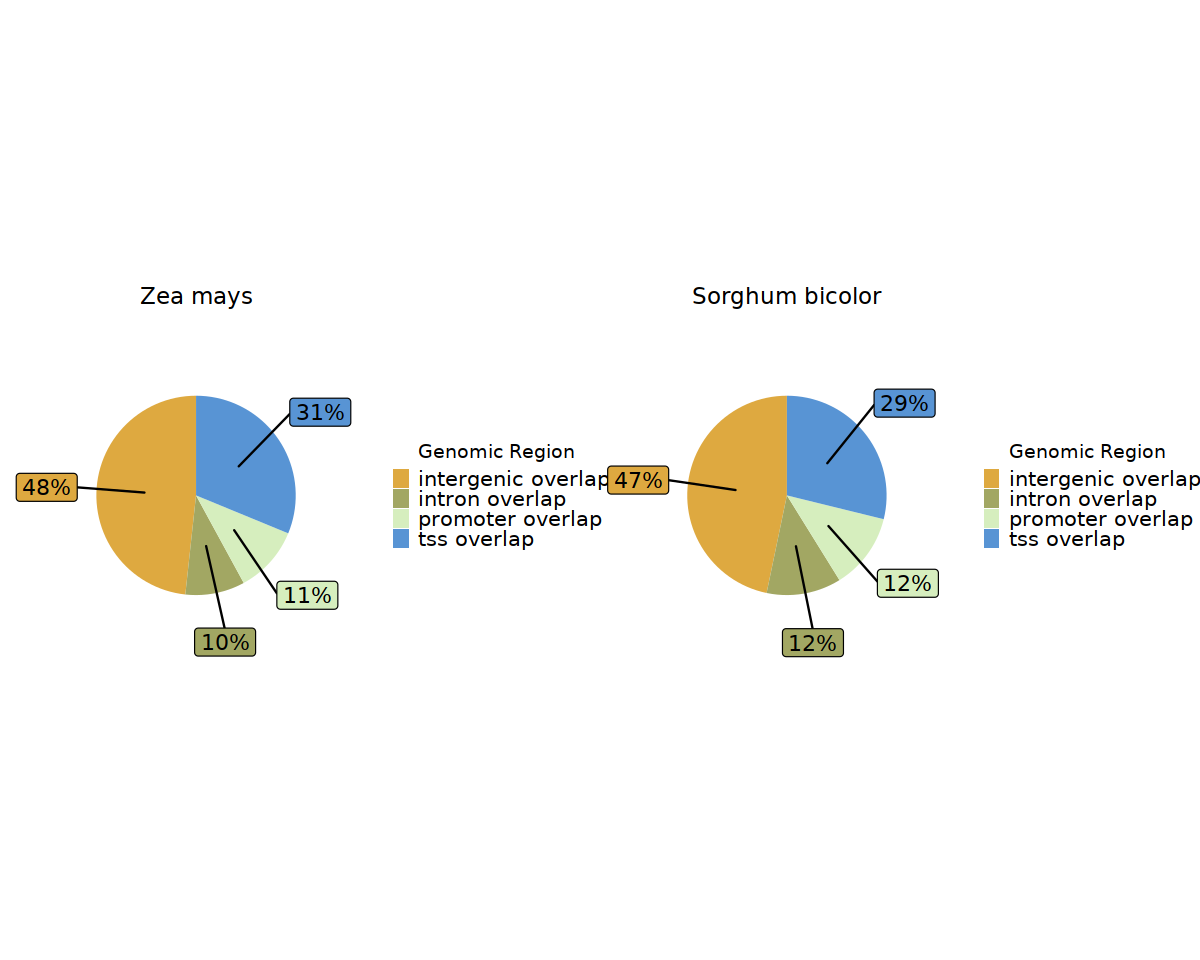

In [16]:
library(patchwork)
options(repr.plot.width=10, repr.plot.height=8)
zm_pie + sb_pie

In [17]:
ggsave("/home/jpm73279/data_copy_over/comparative_single_cell_imgs/gordon_conference/Zm.all_acrs_plot.pdf", plot = zm_pie, device = "pdf", width = 6, height = 7)
ggsave("/home/jpm73279/data_copy_over/comparative_single_cell_imgs/gordon_conference/Sb.all_acrs_plot.pdf", plot = sb_pie, device = "pdf", width = 6, height = 7)

## Breaking down Freatures by class

In [9]:
split_features_generate_pie <- function(counts_matrix, species){
    
    annotation_categorized_ct_split <- counts_matrix  %>% 
     separate(col = acr_name, 
           into = c("acr_number","cell_type"), 
           sep = ";", 
           remove = FALSE)  %>% 
    mutate(cell_type_class = case_when(
        cell_type == "broadly_accessible" ~ "broadly_accessible", 
        cell_type != "broadly_accessible" ~ "cell_type_restricted"
    ))


    broadly_acc_only <- annotation_categorized_ct_split  %>% 
        dplyr::filter(cell_type_class == "broadly_accessible")

    ctr_acc_only <- annotation_categorized_ct_split  %>% 
        dplyr::filter(cell_type_class == "cell_type_restricted")

    pie_broad <- pie_chart(broadly_acc_only, paste0(species, " Broad"))
    pie_acc <- pie_chart(ctr_acc_only, paste0(species, " CTR"))

    pie_broad + pie_acc
    
    
}

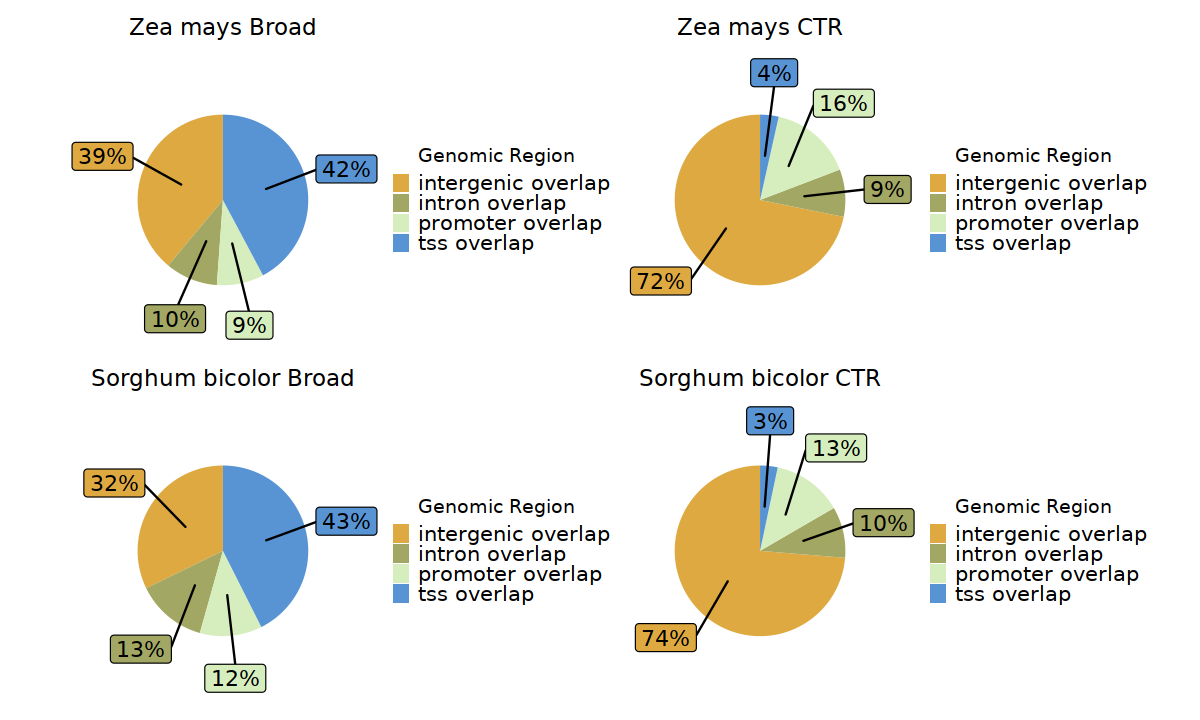

In [20]:
zm_feature_split <- split_features_generate_pie(zm_annotation_categorized, "Zea mays")
sb_feature_split <- split_features_generate_pie(sb_annotation_categorized, "Sorghum bicolor")

options(repr.plot.width=10, repr.plot.height=6)
zm_feature_split/sb_feature_split

In [22]:
ggsave("/home/jpm73279/data_copy_over/comparative_single_cell_imgs/gordon_conference/Zm.split_acr_type.pdf", plot = zm_feature_split, device = "pdf", width = 12, height = 7)
ggsave("/home/jpm73279/data_copy_over/comparative_single_cell_imgs/gordon_conference/Sb.split_acr_type.pdf", plot = sb_feature_split, device = "pdf", width = 12, height = 7)

In [11]:
typeof(zm_feature_split)

[1] "list"

## Run the same anlysis on CNS's

Rows: 71128 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name
dbl (6): start, stop, intron_overlap, tss_overlap, promoter_overlap, interge...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 66054 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name
dbl (6): start, stop, intron_overlap, tss_overlap, promoter_overlap, interge...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,n
<chr>,<int>
intergenic overlap,29728
intron overlap,23267
promoter overlap,9587
tss overlap,3472


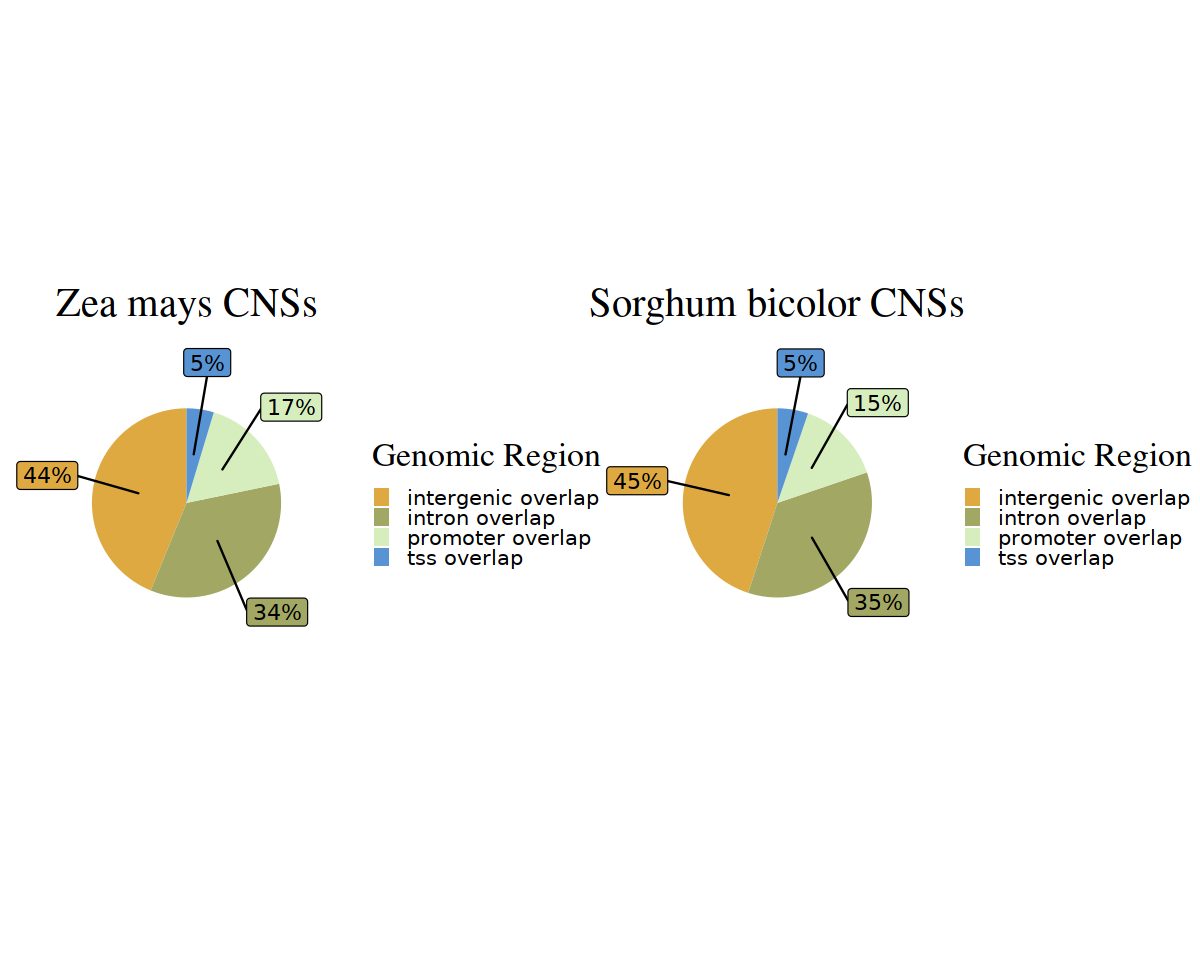

In [2]:
library(tidyverse)
library(readr)
library(ggrepel)

read_my_data <- function(file_path) {
  my_data <- read_delim(file_path, delim = "\t", skip = 1, 
                        col_names = c("chrom", "start", "stop", "acr_name", 
                                     "intron_overlap", 
                                      "tss_overlap", "promoter_overlap", 
                                      "intergenic_overlap"))
    
    
  return(my_data)
}


zm_annotation <- read_my_data("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/00.data/annotate_CNS/Zm.all_CNSs.annotated.bed")
sb_annotation <- read_my_data("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/00.data/annotate_CNS/Sb.all_CNSs.annotated.bed")



categroize_acrs <- function(df) {
    
    df_categorized <- df %>%
    rowwise() %>%
    mutate(class = case_when(
      intron_overlap >= tss_overlap & 
        intron_overlap >= promoter_overlap & 
        intron_overlap >= intergenic_overlap ~ "intron_overlap",
      tss_overlap > 0 ~ "tss_overlap",
      promoter_overlap >= intergenic_overlap ~ "promoter_overlap",
      TRUE ~ "intergenic_overlap"
    ))
  return(df_categorized)
}



zm_annotation_categorized  <- categroize_acrs(zm_annotation)
sb_annotation_categorized <- categroize_acrs(sb_annotation)

  class_counts <- sb_annotation_categorized %>% 
    group_by(class = str_replace_all(class, "_", " ")) %>% 
    summarise(n = n())

class_counts

# Function to generate pie chart
pie_chart <- function(dataframe, species) {
    colors_large <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                  "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                  "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")

    
  # Group the data by class and count the number of observations in each group
  class_counts <- dataframe %>% 
    group_by(class = str_replace_all(class, "_", " ")) %>% 
    summarise(n = n())
  
  # Generate the pie chart
 p <- ggplot(class_counts, aes(x = "", y = n, fill = class)) +
    geom_bar(stat = "identity", width = 1, position = position_stack(vjust = 0.5)) +
    scale_fill_manual(values = colors_large) +
    coord_polar(theta = "y") +
    labs(fill = "Genomic Region") +
    theme_void() +
    theme(legend.position = "right",
          plot.title = element_text(hjust = 0.5),
          text = element_text(family = "Times New Roman", size = 20)) +
    guides(fill = guide_legend(title = "Genomic Region", 
                                title.position = "top", 
                                title.hjust = 0.5, 
                                keywidth = 0.7, 
                                keyheight = 0.5,
                                direction = "vertical",
                                label.position = "right",
                                label.theme = element_text(size = 12)))
    
    
      df2 <- class_counts %>% 
        mutate(csum = rev(cumsum(rev(n))), 
        pos = n/2 + lead(csum, 1),
        pos = if_else(is.na(pos), n/2, pos))
  
  # Add the labels
  p + geom_label_repel(data = df2,
                       aes(y = pos, label = paste0(round(n/sum(n)*100), "%")),
                       size = 4.5, nudge_x = 1, show.legend = FALSE) +
        ggtitle(paste(species)) 

}
    
    
    
    
    
    
    




zm_pie <- pie_chart(zm_annotation_categorized, "Zea mays CNSs")
sb_pie <- pie_chart(sb_annotation_categorized, "Sorghum bicolor CNSs")


library(patchwork)
options(repr.plot.width=10, repr.plot.height=8)
zm_pie + sb_pie